In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

import tensorflow as tf
from tensorflow import keras
import gym

import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [2]:
for env in gym.envs.registry.all():
    print(env)

ec(BattleZone-ramNoFrameskip-v0)
EnvSpec(BattleZone-ramNoFrameskip-v4)
EnvSpec(BeamRider-v0)
EnvSpec(BeamRider-v4)
EnvSpec(BeamRiderDeterministic-v0)
EnvSpec(BeamRiderDeterministic-v4)
EnvSpec(BeamRiderNoFrameskip-v0)
EnvSpec(BeamRiderNoFrameskip-v4)
EnvSpec(BeamRider-ram-v0)
EnvSpec(BeamRider-ram-v4)
EnvSpec(BeamRider-ramDeterministic-v0)
EnvSpec(BeamRider-ramDeterministic-v4)
EnvSpec(BeamRider-ramNoFrameskip-v0)
EnvSpec(BeamRider-ramNoFrameskip-v4)
EnvSpec(Berzerk-v0)
EnvSpec(Berzerk-v4)
EnvSpec(BerzerkDeterministic-v0)
EnvSpec(BerzerkDeterministic-v4)
EnvSpec(BerzerkNoFrameskip-v0)
EnvSpec(BerzerkNoFrameskip-v4)
EnvSpec(Berzerk-ram-v0)
EnvSpec(Berzerk-ram-v4)
EnvSpec(Berzerk-ramDeterministic-v0)
EnvSpec(Berzerk-ramDeterministic-v4)
EnvSpec(Berzerk-ramNoFrameskip-v0)
EnvSpec(Berzerk-ramNoFrameskip-v4)
EnvSpec(Bowling-v0)
EnvSpec(Bowling-v4)
EnvSpec(BowlingDeterministic-v0)
EnvSpec(BowlingDeterministic-v4)
EnvSpec(BowlingNoFrameskip-v0)
EnvSpec(BowlingNoFrameskip-v4)
EnvSpec(Bowling-r

In [3]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([-0.04344601, -0.00255492,  0.0296054 , -0.03070194])

In [4]:
env.render()

True

In [5]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [6]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

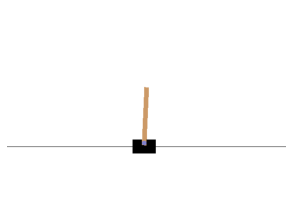

In [8]:
plot_environment(env)
plt.show()

In [9]:
env.action_space

Discrete(2)

In [10]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([-0.03866668,  0.19996362,  0.04454982, -0.25640499])

In [11]:
print(reward)
print(done)
print(info)

1.0
False
{}


In [12]:
def base_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [13]:
obs = env.reset()
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = base_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [14]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.996, 8.802725941434279, 24.0, 68.0)

In [15]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = base_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [16]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                    frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [17]:
plot_animation(frames)

# Neural Network Policies:

In [18]:
n_inputs = 4

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [19]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [19]:
frames = render_policy_net(model)
plot_animation(frames)

In [20]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.087

In [21]:
frames = render_policy_net(model)
plot_animation(frames)

In [22]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, rewards, done, info = env.step(int(action[0, 0].numpy()))
    return obs, rewards, done, grads

In [23]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [24]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    rewards_mean = flat_rewards.mean()
    rewards_std = flat_rewards.std()
    return [(discounted_rewards - rewards_mean) / rewards_std
            for discounted_rewards in all_discounted_rewards]

In [25]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [26]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                                discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [27]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [28]:
env = gym.make("CartPole-v1")
env.seed(42)

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print("\rIteration: {}, mean rewards: {:.1f}".format(
        iteration, total_rewards / n_episodes_per_update), end="")
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                        discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 95, mean rewards: 199.8

KeyboardInterrupt: 

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

In [ ]:
# shape=[s, a, s']
transition_probabilities = [[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
                            [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
                            [None, [0.8, 0.1, 0.1], None]]

# shape=[s, a, s']
rewards = [[[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
           [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
           [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]

In [ ]:
len(transition_probabilities), len(transition_probabilities[0]), len(transition_probabilities[0][0])

In [ ]:
np.full((3, 3), -np.inf)

In [ ]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

Q_values

In [ ]:
gamma = 0.90

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [ ]:
Q_values

In [ ]:
np.argmax(Q_values, axis=1)

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [ ]:
alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

In [ ]:
env = gym.make("CartPole-v0")
input_shape = [4]
n_outputs = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [ ]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [ ]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    if episode > 50:
        training_step(batch_size)

# Deep Q-Variants:

## Fixed Q-value Targets:

In [ ]:
temp_model = keras.models.clone_model(model)
temp_model.set_weights(model.get_weights())

In [ ]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = target.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = temp_model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, temp_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, temp_model.trainable_variables))


for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target.set_weights(temp_model.get_weights())

## Double DQN:

In [ ]:
temp_model = keras.models.clone_model(model)
temp_model.set_weights(model.get_weights())

In [ ]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

def training_step(batch_size, episode=None):
    print("\n\nEpisode:", episode)
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    print("Next States:\n", next_states)
    next_Q_values = temp_model.predict(next_states)
    print("Next Q Values:\n", next_Q_values)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    print("Best Next Actions:\n", best_next_actions)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    print("Next Mask:\n", next_mask)
    print("Target Predict:\n", target.predict(next_states))
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    print("Next Best Q Values:\n", next_best_Q_values)
    target_Q_values = (rewards + (1 - dones) * discount_factor * next_best_Q_values)
    print("Target Q Values:\n", target_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    print("Mask:", mask)
    if episode == 52:
        print(asdasd)
    with tf.GradientTape() as tape:
        all_Q_values = temp_model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, temp_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, temp_model.trainable_variables))

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    if episode > 50:
        training_step(batch_size, episode)    
    if episode % 50 == 0:
        target.set_weights(temp_model.get_weights())

## Dueling DQN:

In [ ]:
K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.Model(inputs=[inputs_states], outputs=[Q_values])